## Reads the spike statistics  summary file and generates a report for quantifying spike sorting 

In [1]:
# Dependencies 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
from scipy.stats import expon, poisson
from scipy.optimize import curve_fit
from scipy.special import erf

# Theunissen Lab Code
import suss.io

In [2]:
# Set paths
rootPathH = '/Users/frederictheunissen/Code/songephys/'
dataPathH = 'data/birds/'

rootPathJ = '/Users/frederictheunissen/Google Drive/My Drive/julie/'
dataPathJ = 'pkl/'


In [3]:
# Read data files 
inPathH = rootPathH+dataPathH+'summarySel.pkl'
fileInH = open(inPathH,"rb")
dfSummaryH = pk.load(fileInH)
fileInH.close()

inPathJ = rootPathJ+dataPathJ+'summarySelJulie.pkl'
fileInJ = open(inPathJ,"rb")
dfSummaryJ = pk.load(fileInJ)
fileInJ.close()

In [4]:
# Number of auditory units

nCellsH = dfSummaryH.shape[0]
nAudH = sum(dfSummaryH['pAud']< 0.01)

nInhH = sum((dfSummaryH['pAud']< 0.01) & (dfSummaryH['zAud']< 0.0))

print("Awake behaving data set:")
print(nAudH,'/',nCellsH, '(', nAudH*100.0/nCellsH, ') auditory units')
print(nInhH,'/',nAudH, '(', nInhH*100.0/nAudH, ') are inhibited by sound')

nCellsJ = dfSummaryJ.shape[0]
nAudJ = sum(dfSummaryJ['pAud']< 0.01)

nInhJ = sum((dfSummaryJ['pAud']< 0.01) & (dfSummaryJ['zAud']< 0.0))

print("Urethane anesthetized data set:")
print(nAudJ,'/',nCellsJ, '(', nAudJ*100.0/nCellsJ, ') auditory units')
print(nInhJ,'/',nAudJ, '(', nInhJ*100.0/nAudJ, ') are inhibited by sound')

# Repeat with single Units by SNR > 5

nAudSUH = sum((dfSummaryH['pAud']< 0.01) & (dfSummaryH['snr'] >= 5.0))

nInhSUH = sum((dfSummaryH['pAud']< 0.01) & (dfSummaryH['zAud']< 0.0) & (dfSummaryH['snr'] >= 5.0))

print("Awake behaving data set Single Units:")
print(nAudSUH,'/',nCellsH, '(', nAudSUH*100.0/nCellsH, ') auditory single units')
print(nInhSUH,'/',nAudSUH, '(', nInhSUH*100.0/nAudSUH, ') are inhibited by sound')


nAudSUJ = sum( (dfSummaryJ['pAud']< 0.01) & (dfSummaryJ['snr'] >= 5.0))

nInhSUJ = sum((dfSummaryJ['pAud']< 0.01) & (dfSummaryJ['zAud']< 0.0) & (dfSummaryJ['snr'] >= 5.0))

print("Urethane anesthetized data set:")
print(nAudSUJ,'/',nCellsJ, '(', nAudSUJ*100.0/nCellsJ, ') auditory single units')
print(nInhSUJ,'/',nAudSUJ, '(', nInhSUJ*100.0/nAudSUJ, ') are inhibited by sound')


Awake behaving data set:
439 / 732 ( 59.97267759562842 ) auditory units
62 / 439 ( 14.123006833712983 ) are inhibited by sound
Urethane anesthetized data set:
1032 / 1207 ( 85.50124275062137 ) auditory units
15 / 1032 ( 1.4534883720930232 ) are inhibited by sound
Awake behaving data set Single Units:
292 / 732 ( 39.89071038251366 ) auditory single units
46 / 292 ( 15.753424657534246 ) are inhibited by sound
Urethane anesthetized data set:
609 / 1207 ( 50.45567522783762 ) auditory single units
13 / 609 ( 2.134646962233169 ) are inhibited by sound


In [69]:
# Read the spike sorted data
inPathSpikeH = rootPathH+dataPathH+'spikeSortStats.pkl'
fileinSpikeH = open(inPathSpikeH,"rb")    


spikeInH = pk.load(fileinSpikeH)

In [42]:
audUnits = dfSummaryH[(dfSummaryH['pAud']< 0.01) & (dfSummaryH['snr'] >= 5.0)]
unitNamesH = []
for index, row in audUnits.iterrows():
    unitNamesH.append(row['site']+ '_' + row['unit'])

In [43]:
# Read the results of Part 1 Runs that includes all neurons

# Read the PC and Confusion matrices data base
# Use the following data if NW
#inPath = rootPath+dataPath+'HerminaDataBase1UnitPCNW.pkl'

inPath = rootPathH+dataPathH+'HerminaDataBase1UnitPC.pkl'
fileIn = open(inPath,"rb")
unitNamesFull = pk.load(fileIn)
confMatTot = pk.load(fileIn)
pcc = pk.load(fileIn)
fileIn.close()

# These are the neurons that we will be keeping  Use 13 if NW 12 otherwise.
indGood = np.argwhere(pcc > 12).flatten()
nGood = indGood.shape[0]


pccGood = pcc[indGood]
unitNamesGoodH = [unitNamesFull[i] for i in indGood]

indSort = np.flip(np.argsort(pccGood))


In [48]:
# This section is to check whether I had all the information saved previously - does not need to be run

audUnits = dfSummaryH[(dfSummaryH['pAud']< 0.01) & (dfSummaryH['snr'] >= 5.0)]
i = 0
for index, row in audUnits.iterrows():
    hist, bin_edges = np.histogram(spikeInH['backIsi'][i], bins=30, range = (0,0.030))
    print(i+1, '/', nAudSUH, ':', row['bird'], row['site'], row['unit'], 'Time=', spikeInH['tottimeB'][i], 
                                  'N=', spikeInH['nspikesB'][i], 'r=', hist[0], 'fc=', spikeInH['fc'][i], 'snr=', row['snr'])
    i += 1

1 / 292 : ZF7F ZF7F_5t_190720_152938 goodPlayback-e16-c1.pkl Time= 435.0 N= 1237 r= 2 fc= 0.5 snr= 5.252660653982749
2 / 292 : ZF7F ZF7F_5t_190720_152938 goodPlayback-e18-c11.pkl Time= 167.5 N= 115 r= 0 fc= 0.0 snr= 8.012569980629404
3 / 292 : ZF7F ZF7F_5t_190720_152938 goodPlayback-e18-c12.pkl Time= 126.0 N= 493 r= 0 fc= 0.0 snr= 5.052138022324443
4 / 292 : ZF7F ZF7F_5t_190720_152938 goodPlayback-e19-c64.pkl Time= 332.0 N= 9775 r= 2 fc= 0.0034867553527520023 snr= 12.046316219499722
5 / 292 : ZF7F ZF7F_5t_190720_152938 goodPlayback-e19-c65.pkl Time= 293.0 N= 8462 r= 89 fc= 0.2394009027401513 snr= 7.570900275156755
6 / 292 : ZF7F ZF7F_5t_190720_152938 goodPlayback-e22-c19.pkl Time= 507.0 N= 1762 r= 7 fc= 0.5 snr= 5.341993398742914
7 / 292 : ZF7F ZF7F_5t_190720_152938 goodPlayback-e9-c7.pkl Time= 150.0 N= 1013 r= 5 fc= 0.5 snr= 5.359689908076179
8 / 292 : ZF7F ZF7F_8_5t_190809_133540 goodPlayback-e16-c36.pkl Time= 470.5 N= 8205 r= 176 fc= 0.5 snr= 5.416767455000541
9 / 292 : ZF7F ZF7F_8_

112 / 292 : ZF5M ZF5M_8t_190627_132428 goodPlayback-e10-c15.pkl Time= 289.5 N= 2685 r= 41 fc= 0.5 snr= 5.167795734841548
113 / 292 : ZF5M ZF5M_8t_190627_132428 goodPlayback-e15-c32.pkl Time= 159.5 N= 184 r= 5 fc= 0.5 snr= 6.654356218935676
114 / 292 : ZF5M ZF5M_8t_190627_132428 goodPlayback-e12-c76.pkl Time= 237.0 N= 392 r= 0 fc= 0.0 snr= 7.166308922863116
115 / 292 : ZF5M ZF5M_8t_190627_132428 goodPlayback-e14-c32.pkl Time= 149.5 N= 89 r= 0 fc= 0.0 snr= 5.321706218301159
116 / 292 : ZF5M ZF5M_8t_190627_132428 goodPlayback-e19-c39.pkl Time= 514.5 N= 405 r= 0 fc= 0.0 snr= 7.154069682221996
117 / 292 : ZF5M ZF5M_8t_190628_100257 goodPlayback-e11-c1.pkl Time= 52.0 N= 113 r= 0 fc= 0.0 snr= 5.055812196500252
118 / 292 : ZF5M ZF5M_8t_190628_100257 goodPlayback-e10-c14.pkl Time= 43.5 N= 361 r= 5 fc= 0.5 snr= 5.2951007363357565
119 / 292 : ZF5M ZF5M_8t_190628_124320 goodPlayback-e11-c1.pkl Time= 64.0 N= 119 r= 0 fc= 0.0 snr= 5.315680529657058
120 / 292 : ZF5M ZF5M_8t_190628_124320 goodPlayback

184 / 292 : ZF5M ZF5M_12t_190707_102304 goodPlayback-e15-c79.pkl Time= 236.5 N= 296 r= 2 fc= 0.5 snr= 6.052138970199081
185 / 292 : ZF4F ZF4F_2t_190611_160843 goodPlayback-e11-c6.pkl Time= 183.5 N= 2392 r= 43 fc= 0.5 snr= 5.963863341593332
186 / 292 : ZF4F ZF4F_2t_190611_160843 goodPlayback-e12-c1.pkl Time= 185.5 N= 4542 r= 122 fc= 0.5 snr= 5.669797821277207
187 / 292 : ZF4F ZF4F_2t_190611_160843 goodPlayback-e17-c3.pkl Time= 184.5 N= 3606 r= 77 fc= 0.5 snr= 5.238627417838516
188 / 292 : ZF4F ZF4F_2t_190611_160843 goodPlayback-e17-c2.pkl Time= 74.0 N= 381 r= 0 fc= 0.0 snr= 8.31231364181001
189 / 292 : ZF4F ZF4F_2t_190611_160843 goodPlayback-e18-c8.pkl Time= 183.0 N= 1057 r= 10 fc= 0.5 snr= 5.182950356909551
190 / 292 : ZF4F ZF4F_2t_190611_160843 goodPlayback-e19-c12.pkl Time= 185.0 N= 2037 r= 43 fc= 0.5 snr= 5.170416734126579
191 / 292 : ZF4F ZF4F_2t_190611_160843 goodPlayback-e19-c11.pkl Time= 169.0 N= 459 r= 1 fc= 0.5 snr= 8.036933441897629
192 / 292 : ZF4F ZF4F_2t_190611_160843 good

272 / 292 : ZF4F ZF4F_6t_190616_142033 goodPlayback-e19-c37.pkl Time= 36.5 N= 258 r= 0 fc= 0.0 snr= 8.90642139380343
273 / 292 : ZF4F ZF4F_6t_190616_142033 goodPlayback-e19-c38.pkl Time= 67.0 N= 656 r= 3 fc= 0.3716974060213365 snr= 7.952020649208992
274 / 292 : ZF4F ZF4F_6t_190616_142033 goodPlayback-e20-c69.pkl Time= 167.0 N= 705 r= 8 fc= 0.5 snr= 5.8326259891076475
275 / 292 : ZF4F ZF4F_6t_190616_142033 goodPlayback-e21-c46.pkl Time= 43.0 N= 102 r= 0 fc= 0.0 snr= 5.976540310516237
276 / 292 : ZF4F ZF4F_6t_190616_142033 goodPlayback-e21-c44.pkl Time= 194.0 N= 138 r= 0 fc= 0.0 snr= 5.2850835444085105
277 / 292 : ZF4F ZF4F_8_5t_190621_100019 goodPlayback-e10-c92.pkl Time= 21.0 N= 25 r= 0 fc= 0.0 snr= 8.13409653067358
278 / 292 : ZF4F ZF4F_8_5t_190621_100019 goodPlayback-e18-c117.pkl Time= 54.5 N= 104 r= 0 fc= 0.0 snr= 13.410839913110868
279 / 292 : ZF4F ZF4F_8_5t_190621_100019 goodPlayback-e18-c122.pkl Time= 22.5 N= 194 r= 4 fc= 0.5 snr= 5.092752398388432
280 / 292 : ZF4F ZF4F_6_5_19061

In [15]:
def expfun(x, l):
    return (l* np.exp(-l*x))

In [16]:
def calcQ(nbins, tbin, Acc, totTime):
    # This code matches the code in spikesort2. postprocess ccg
    
    # Get the total number of spikes and set zero point to 0
    N = Acc[nbins]
    Acc[nbins] = 0
    
    # THis first index range corresponds to the CCG shoulders
    irange1 = np.hstack((np.array(range(1, int(nbins/2-1))),np.array(range(int(3/2*nbins), 2*nbins-1))) )

    irange2 = np.array(range(nbins-50,nbins-11))
    irange3 = np.array(range(nbins+11, nbins+49))

    # normalize the shoulders by what's expected from the mean firing rates
    # a non-refractive poisson process should yield 1

    Q00 = np.sum(Acc[irange1]) / (len(irange1)*tbin* N * N/totTime)
    Q01 = np.sum(Acc[irange2]) / (len(irange2)*tbin* N * N/totTime) 
    Q01 = max([Q01, np.sum(Acc[irange3]) / (len(irange3)*tbin* N * N/totTime) ]) # compare to the other shoulder

    R00 = max([np.mean(Acc[irange2]), np.mean(Acc[irange3])]) # take the biggest shoulder
    R00 = max([R00, np.mean(Acc[irange1])]) # compare this to the asymptotic shoulder

    Qi = np.zeros(10)
    Ri = np.zeros(10)
    for i in range(1,11):
        irange = np.array(range(nbins-i,nbins+i)) # for this central range of the CCG
        Qi0 = np.sum(Acc[irange]) / (2*i*tbin* N * N/totTime) # compute the same normalized ratio as above. this should be 1 if there is no refractoriness
        Qi[i-1] = Qi0 # save the normalized probability

        n = np.sum(Acc[irange])/2
        lam = R00 * i

    # this is tricky: we approximate the Poisson likelihood with a gaussian of equal mean and variance
    # that allows us to integrate the probability that we would see <N spikes in the center of the
    # cross-correlogram from a distribution with mean R00*i spikes
        p = 1/2 * (1+ erf((n - lam)/np.sqrt(2*lam)))

        Ri[i-1] = p # keep track of p for each bin size i


    Qin = Qi/Q00 # normalize the normalized refractory index in two different ways
    Qin1 = Qi/Q01
    
    Acc[nbins] = N
    
    return Qi, Q00, Q01, Ri

# Calculate the cross correlogram and the index of contamination as in KS2
#Nbins =500;
#[K, Qi, Q00, Q01, Qi_pvalues] = ccg(Cell.Spike_arrival_times*(10^-6), Cell.Spike_arrival_times*(10^-6), Nbins, 10^-3); % % compute the auto-correlogram with 500 bins at 1ms bins
#[Q, Imin] = min(Qi/(max(Q00, Q01))); % Q is a measure of refractoriness
#Qpval = Qi_pvalues(Imin); % Qpval is the p-value of the test of refractoriness against a Poisson distribution

In [102]:
# Loop through all neurons to generate statistics
REFTIME = 0.002 # Refractory time in s
HISTIME = 0.1 # Length of histogram to estimate exponential
HISTIMEMIN = 0.01 # Starting isi time point for exponential fit

nbins = 500     # Number of bins in the auto-correlation
tbin = 0.001    # size of bins in ms
dt = nbins*tbin # Maximum time in auto-correlation

# Dictionary of spike stats
spikeStatsH = {'SNR' : [], 'ISIViolation' : [], 'Qisi' : [], 'Pisi': [], 'Qisi' : [], 'Qacc' : [], 'Pacc' : []}

for i, ISI in enumerate(spikeInH['stimIsi']):
 
    # Select only neurons that were used in the analysis
    if not (unitNamesH[i] in unitNamesGoodH):
        continue
    if ('old' in unitNamesH[i]):
        continue

    # Calculate the ISI statistics
    p, xbin = np.histogram(ISI, bins=100, range = (0,HISTIME), density = True)
    xval = (xbin + np.roll(xbin, -1))/2.0
    xval = xval[0:-1]

    # fit section beyond 10 ms with exponential
    lfit, pcov = curve_fit(expfun, xval[xval > HISTIMEMIN], p[xval > HISTIMEMIN])
    # plt.plot(xval, expfun(xval, lfit[0]), 'r')
    
    # Probability of finding an isi within the prefractory period per second given poisson
    pisiRefPoisson = expon.cdf(REFTIME, scale = 1/lfit[0])

    # Expected number from exponential fit
    iint = np.max(np.argwhere(xbin<= REFTIME))
    pisiRefActual = np.sum(p[0:iint])*tbin
    Qisi = pisiRefActual/pisiRefPoisson

    # Probability of N events 
    nActual = pisiRefActual*len(ISI[ISI<HISTIME])
    nPoisson = pisiRefPoisson*len(ISI[ISI<HISTIME])
    pPoisson = poisson.cdf(nActual, nPoisson)
    Qisi = pisiRefActual/pisiRefPoisson
    
    # Another measure of ISI
    ISIViolation = sum(ISI<REFTIME)/len(ISI)*100;

    # Now the Acc statistic
    
    Qi, Q00, Q01, Ri = calcQ(nbins, tbin, spikeInH['sAcc'][i], spikeInH['tottimeS'][i])
    Q = Qi/np.max([Q00, Q01])
    
    
    # Store data
    spikeStatsH['SNR'].append(spikeInH['snr'][i])
    spikeStatsH['Pisi'].append(pPoisson)
    spikeStatsH['Qisi'].append(Qisi)
    spikeStatsH['ISIViolation'].append(ISIViolation)
    spikeStatsH['Pacc'].append(Ri[1])
    spikeStatsH['Qacc'].append(Q[1])
    
    if (ISIViolation > 5):
        print('Cell', unitNamesH[i])
        print('\tISI violation:', ISIViolation)
        print('\tQisi:', pPoisson)
        print('\tQisi:', Qisi)
        print('\tPacc:', Ri[1])
        print('\tQacc:', Q[1])


Cell ZF7F_8_5t_190809_133540_goodPlayback-e17-c29.pkl
	ISI violation: 7.587729491052754
	Qisi: 3.2503196469864676e-09
	Qisi: 0.8027381908841609
	Pacc: 0.0
	Qacc: 0.7077479778629203
Cell ZF7F_7t_190806_115742_goodPlayback-e17-c31.pkl
	ISI violation: 5.152762859529777
	Qisi: 0.9999685664085699
	Qisi: 1.103037077765553
	Pacc: 3.70532194668427e-05
	Qacc: 0.9063831037217636
Cell ZF6M_2t_190716_085010_goodPlayback-e18-c27.pkl
	ISI violation: 10.21635830553028
	Qisi: 1.0
	Qisi: 3.8976182790128986
	Pacc: 1.0
	Qacc: 1.2651388839618292
Cell ZF6M_7_5t_190723_100723_goodPlayback-e13-c131.pkl
	ISI violation: 11.781371738873805
	Qisi: 1.0
	Qisi: 8.292661037864796
	Pacc: 1.0
	Qacc: 1.2427788523533203
Cell ZF6M_8t_190725_105432_goodPlayback-e15-c71.pkl
	ISI violation: 7.778153533987149
	Qisi: 1.0
	Qisi: 1.6934149205324893
	Pacc: 0.9948754582382282
	Qacc: 1.0774462378466403
Cell ZF5M_9_5t_190701_125653_goodPlayback-e10-c115.pkl
	ISI violation: 9.134009317621267
	Qisi: 1.0
	Qisi: 8.404979433947863
	Pacc

Poisson Rate 70.62538264638037
Qisi =  0.02425459948870372 ( 77.0 / 3174.655596183388 )
Poisson p= 0.0
Q00: 0.7409386993102732 Q01 1.3781998797829538 Qi 0.04312823978281584 Q 0.03129316756986505


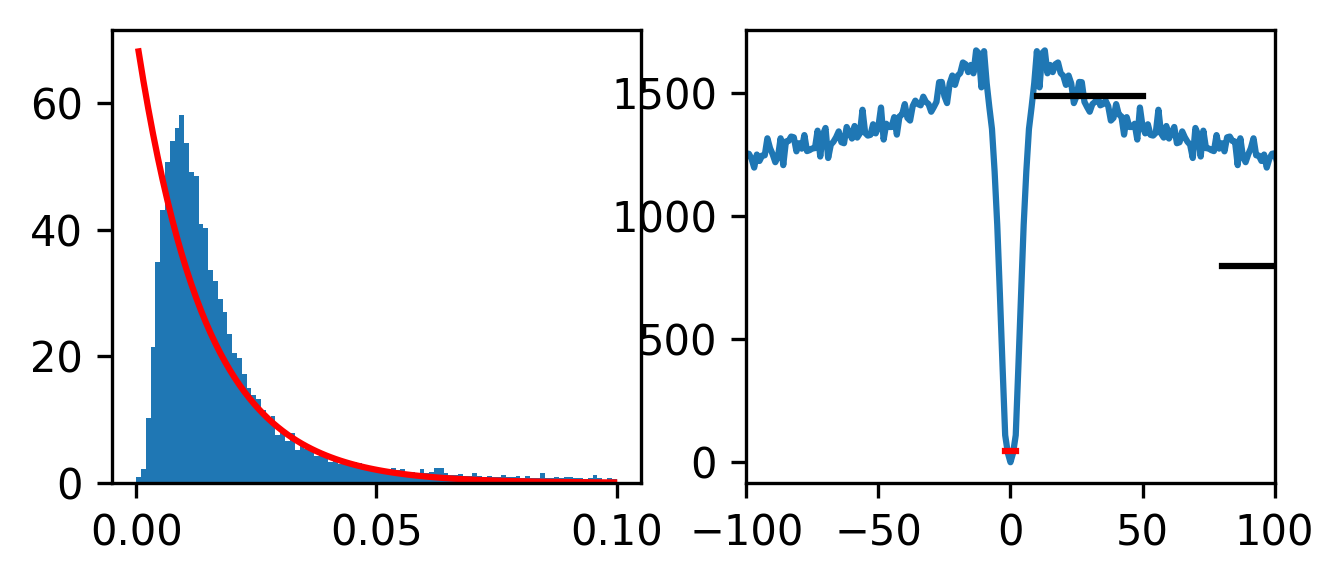

In [108]:
# Make some plots to illustrate spike statistics methods
icell = 3
ISI = spikeInH['stimIsi'][icell]

plt.figure(figsize=(5,2), dpi=300)
 
# Calculate the ISI statistics and plot histogram
plt.subplot(1,2,1)
p, xbin, pa = plt.hist(ISI, bins=100, range = (0,HISTIME), density = True)
xval = (xbin + np.roll(xbin, -1))/2.0
xval = xval[0:-1]

# fit section beyond 10 ms with exponential
lfit, pcov = curve_fit(expfun, xval[xval > HISTIMEMIN], p[xval > HISTIMEMIN])
plt.plot(xval, expfun(xval, lfit[0]), 'r')
    
# Probability of finding an isi within the prefractory period per second given poisson
pisiRefPoisson = expon.cdf(REFTIME, scale = 1/lfit[0])

# Expected number from exponential fit
iint = np.max(np.argwhere(xbin<= REFTIME))
pisiRefActual = np.sum(p[0:iint])*tbin
Qisi = pisiRefActual/pisiRefPoisson

# Probability of N events 
nActual = pisiRefActual*len(ISI[ISI<HISTIME])
nPoisson = pisiRefPoisson*len(ISI[ISI<HISTIME])
pPoisson = poisson.cdf(nActual, nPoisson)
Qisi = pisiRefActual/pisiRefPoisson

print('Poisson Rate', lfit[0])
print('Qisi = ', Qisi, '(', nActual, '/', nPoisson, ')')
print('Poisson p=', pPoisson)

# Now the Acc statistic
ACC =  spikeInH['sAcc'][icell] 
totTime = spikeInH['tottimeS'][icell]
Qi, Q00, Q01, Ri = calcQ(nbins, tbin, ACC, totTime)
Q = Qi/np.max([Q00, Q01])

# THis first index range corresponds to the CCG shoulders
irange1 = np.hstack((np.array(range(1, int(nbins/2-1))),np.array(range(int(3/2*nbins), 2*nbins-1))) )

irange2 = np.array(range(nbins-50,nbins-11))
irange3 = np.array(range(nbins+11, nbins+49))

Q00N = Q00*(tbin* NS * NS/totTime)
Q01N = Q01*(tbin* NS * NS/totTime)
QiN = Qi[1]*(tbin* NS * NS/totTime)

plt.subplot(1,2,2)

tval = np.linspace(-500, 500, num=2*nbins+1)
NS = ACC[nbins]
ACC[nbins] = 0
plt.plot(tval, ACC)
plt.plot([10, 50], [Q01N, Q01N], 'k')
plt.plot([80, 100], [Q00N, Q00N], 'k')
plt.plot([-2, 2], [QiN, QiN], 'r')
plt.xlim(-100, 100)
ACC[nbins] = NS

print('Q00:', Q00, 'Q01', Q01, 'Qi', Qi[1], 'Q', Q[1] )
plt.savefig('/Users/frederictheunissen/Desktop/spikeStats.eps')


In [109]:
spikeStatsdfH = pd.DataFrame.from_dict(spikeStatsH)
spikeStatsdfH.describe()

,SNR,ISIViolation,Qisi,Pisi,Qacc,Pacc
count,91.000000,91.000000,91.000000,9.100000e+01,91.000000,9.100000e+01
mean,7.426554,2.923862,0.990039,3.209713e-01,0.568998,1.655094e-01
std,2.523287,3.227859,1.659648,4.547274e-01,0.477367,3.464883e-01
min,5.002063,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,5.514518,0.571657,0.123108,3.660463e-52,0.167005,0.000000e+00
50%,6.504423,1.938776,0.623220,1.075795e-05,0.525692,9.403400e-10
75%,9.031117,4.209952,1.118038,9.922736e-01,0.849470,4.940821e-02
max,15.562641,17.785709,10.262292,1.000000e+00,2.282468,1.000000e+00


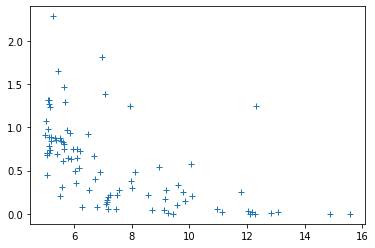

In [111]:
plt.plot(spikeStatsdfH['SNR'], spikeStatsdfH['Qacc'],'+')

In [104]:
# Repeat for Julies Data
# Read the spike sorted data
inPathSpikeJ = rootPathJ+dataPathJ+'spikeSortStats.pkl'
fileinSpikeJ = open(inPathSpikeJ,"rb")    


spikeInJ = pk.load(fileinSpikeJ)

audUnits = dfSummaryJ[(dfSummaryJ['pAud']< 0.01) & (dfSummaryJ['snr'] >= 5.0)]
unitNamesJ = []
for index, row in audUnits.iterrows():
    pklfile = row['unit'].split('/')[-1]
    unitName = pklfile.split('.')[0]
    unitNamesJ.append(unitName)
    
    

In [105]:
# Read the results of Part 1 Runs that includes all neurons

# Read the PC and Confusion matrices data base
# Use the following data if NW
#inPath = rootPath+dataPath+'HerminaDataBase1UnitPCNW.pkl'

inPath = rootPathJ+dataPathJ+'JulieDataBase1UnitPCNW.pkl'
fileIn = open(inPath,"rb")
unitNamesFull = pk.load(fileIn)
confMatTot = pk.load(fileIn)
pcc = pk.load(fileIn)
fileIn.close()

# These are the neurons that we will be keeping  Use 13 if NW 12 otherwise.
indGood = np.argwhere(pcc > 13).flatten()
nGood = indGood.shape[0]


pccGood = pcc[indGood]
unitNamesGoodJ = [unitNamesFull[i] for i in indGood]

indSort = np.flip(np.argsort(pccGood))



In [106]:
# Repeat for Julie's Data
# Loop through all neurons to generate statistics
REFTIME = 0.002 # Refractory time in s
HISTIME = 0.1 # Length of histogram to estimate exponential
HISTIMEMIN = 0.01 # Starting isi time point for exponential fit

nbins = 500     # Number of bins in the auto-correlation
tbin = 0.001    # size of bins in ms
dt = nbins*tbin # Maximum time in auto-correlation

# Dictionary of spike stats
spikeStatsJ = {'SNR' : [], 'ISIViolation' : [], 'Qisi' : [], 'Pisi': [], 'Qisi' : [], 'Qacc' : [], 'Pacc' : []}

for i, ISI in enumerate(spikeInJ['stimIsi']):
 
    # Select only neurons that were used in the analysis
    if not (unitNamesJ[i] in unitNamesGoodJ):
        continue

    # Calculate the ISI statistics
    p, xbin = np.histogram(ISI, bins=100, range = (0,HISTIME), density = True)
    xval = (xbin + np.roll(xbin, -1))/2.0
    xval = xval[0:-1]

    # fit section beyond 10 ms with exponential
    lfit, pcov = curve_fit(expfun, xval[xval > HISTIMEMIN], p[xval > HISTIMEMIN])
    # plt.plot(xval, expfun(xval, lfit[0]), 'r')

    # Probability of finding an isi within the prefractory period per second given poisson
    pisiRefPoisson = expon.cdf(REFTIME, scale = 1/lfit[0])

    # Expected number from exponential fit
    iint = np.max(np.argwhere(xbin<= REFTIME))
    pisiRefActual = np.sum(p[0:iint])*tbin
    Qisi = pisiRefActual/pisiRefPoisson

    # Probability of N events 
    nActual = pisiRefActual*len(ISI[ISI<HISTIME])
    nPoisson = pisiRefPoisson*len(ISI[ISI<HISTIME])
    pPoisson = poisson.cdf(nActual, nPoisson)
    Qisi = pisiRefActual/pisiRefPoisson
    
    # Another measure of ISI
    ISIViolation = sum(ISI<REFTIME)/len(ISI)*100;

    # Now the Acc statistic
    
    Qi, Q00, Q01, Ri = calcQ(nbins, tbin, spikeInJ['sAcc'][i], spikeInJ['tottimeS'][i])
    Q = Qi/np.max([Q00, Q01])
    
    
    # Store data
    spikeStatsJ['SNR'].append(spikeInJ['snr'][i])
    spikeStatsJ['Pisi'].append(pPoisson)
    spikeStatsJ['Qisi'].append(Qisi)
    spikeStatsJ['ISIViolation'].append(ISIViolation)
    spikeStatsJ['Pacc'].append(Ri[0])
    spikeStatsJ['Qacc'].append(Q[0])
    
    if (ISIViolation > 5):
        print('Cell', unitNamesJ[i])
        print('\tISI violation:', ISIViolation)
        print('\tQisi:', pPoisson)
        print('\tQisi:', Qisi)
        print('\tPacc:', Ri[0])
        print('\tQacc:', Q[0])

Cell Site3_L2500R2300_e18_s0_ss1
	ISI violation: 6.554775091179252
	Qisi: 4.9700654694585435e-52
	Qisi: 0.7224050845381292
	Pacc: 0.0
	Qacc: 0.43759697439875866
Cell Site3_L2500R2300_e22_s1_ss1
	ISI violation: 8.779668956901936
	Qisi: 3.39133038513624e-18
	Qisi: 0.8380631045817382
	Pacc: 0.0
	Qacc: 0.4434653656859164
Cell Site2_L2000R1600_e21_s1_ss1
	ISI violation: 10.074014802960592
	Qisi: 1.526475748106924e-83
	Qisi: 0.6961472529547141
	Pacc: 0.0
	Qacc: 0.69328532659806
Cell Site3_L2500R2300_e20_s1_ss1
	ISI violation: 7.82051282051282
	Qisi: 1.0
	Qisi: 1.1857772833617954
	Pacc: 0.0
	Qacc: 0.7064907545218335
Cell Site3_L2500R2300_e20_s1_ss2
	ISI violation: 5.789106145251396
	Qisi: 0.0
	Qisi: 0.4164486835404448
	Pacc: 0.0
	Qacc: 0.4429637205944287
Cell Site1_L1500R1500_e19_s0_ss1
	ISI violation: 12.227561506758095
	Qisi: 6.910330370502354e-218
	Qisi: 0.6982230293056264
	Pacc: 0.0
	Qacc: 0.7550721606358503
Cell Site2_L2000R1600_e17_s1_ss2
	ISI violation: 8.143716287432575
	Qisi: 1.27296

Cell Site4_L1500R1900_e14_s0_ss2
	ISI violation: 5.280961354298601
	Qisi: 0.0
	Qisi: 0.3650585882756258
	Pacc: 0.0
	Qacc: 0.26131045785821394
Cell Site5_L1800R2100_e22_s0_ss1
	ISI violation: 6.03651024750812
	Qisi: 1.0
	Qisi: 1.618803969086797
	Pacc: 0.0018605348336798722
	Qacc: 0.8511978950283894
Cell Site2_L1100R1450_e3_s0_ss1
	ISI violation: 10.704295704295705
	Qisi: 1.0
	Qisi: 4.014262422906251
	Pacc: 0.0
	Qacc: 0.6220328667072427
Cell Site2_L1100R1450_e28_s0_ss3
	ISI violation: 5.122717849261018
	Qisi: 1.0
	Qisi: 1.565079798466065
	Pacc: 0.05017011351480333
	Qacc: 0.8993083003952571
Cell Site2_L1100R1450_e23_s0_ss2
	ISI violation: 11.168552477565354
	Qisi: 1.0
	Qisi: 3.0259771017576953
	Pacc: 0.0
	Qacc: 0.7080819884407668
Cell Site5_L1800R2100_e31_s0_ss3
	ISI violation: 6.404520838238757
	Qisi: 0.9994158221916402
	Qisi: 1.1516270660465946
	Pacc: 5.551115123125783e-17
	Qacc: 0.4764766839378238
Cell Site3_L1250R1650_e5_s0_ss1
	ISI violation: 6.798729088315393
	Qisi: 0.0
	Qisi: 0.397

Cell Site2_L1000R900_e3_s0_ss1
	ISI violation: 6.930211835230264
	Qisi: 0.9620520945492247
	Qisi: 1.043752214314523
	Pacc: 0.0
	Qacc: 0.5964025393839641
Cell Site3_L1200R1200_e13_s0_ss2
	ISI violation: 7.109283196239718
	Qisi: 5.845939121685614e-30
	Qisi: 0.7686598452026507
	Pacc: 0.0
	Qacc: 0.4172196747458061
Cell Site3_L1200R1200_e15_s0_ss1
	ISI violation: 7.225111441307577
	Qisi: 1.0
	Qisi: 1.6461383250736665
	Pacc: 0.29266408155027823
	Qacc: 0.9760833291196844
Cell Site3_L1200R1200_e20_s0_ss2
	ISI violation: 9.99754058042302
	Qisi: 1.0
	Qisi: 7.984554066467279
	Pacc: 4.52279047824522e-07
	Qacc: 0.6641230769230769
Cell Site3_L1200R1200_e21_s0_ss1
	ISI violation: 14.97275775356245
	Qisi: 1.0
	Qisi: 9.461705280075929
	Pacc: 3.3306690738754696e-16
	Qacc: 0.7641939029587924
Cell Site3_L1200R1200_e22_s0_ss1
	ISI violation: 14.35576923076923
	Qisi: 1.0
	Qisi: 8.214939933111134
	Pacc: 1.0
	Qacc: 1.4423426400132164
Cell Site3_L1200R1200_e23_s0_ss1
	ISI violation: 6.754322766570605
	Qisi: 1.

In [107]:
spikeStatsdfJ = pd.DataFrame.from_dict(spikeStatsJ)
spikeStatsdfJ.describe()

,SNR,ISIViolation,Qisi,Pisi,Qacc,Pacc
count,408.000000,408.000000,408.000000,4.080000e+02,408.000000,4.080000e+02
mean,6.597000,4.393448,1.359680,3.755302e-01,0.513218,9.891452e-02
std,1.433948,3.284408,2.055524,4.713187e-01,0.414317,2.668490e-01
min,5.004721,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,5.577550,1.932018,0.376768,1.652726e-58,0.251890,0.000000e+00
50%,6.218819,3.803837,0.740956,1.337353e-06,0.437852,1.942890e-16
75%,7.149033,6.002704,1.389642,1.000000e+00,0.692479,1.023628e-03
max,13.120614,19.065934,20.399284,1.000000e+00,3.521951,1.000000e+00


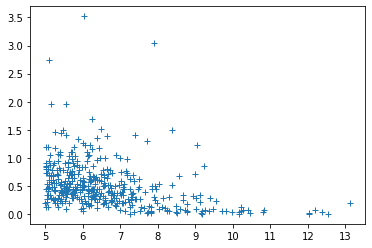

In [113]:
plt.plot(spikeStatsdfJ['SNR'], spikeStatsdfJ['Qacc'],'+')